In [126]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import itertools
import statsmodels.formula.api as smf
import sys
import time
import requests
# Plotting packages
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from io import BytesIO

<span style="font-family: verdana; color: green; font-size: 20px;font-weight: bold;">Autoregressive Model</span>

In [127]:
#electricity consumption data
electr_residential = pd.read_csv('../../../data/tidy/residential-electricity-2016to2022.csv') 
electr_commer_indust = pd.read_csv('../../../data/tidy/commercial-electricity-2016to2022.csv')


#emissions data
#electr_residential = pd.read_csv('../../../results/residential_emissions-electricity.csv') 
#electr_commer_indust = pd.read_csv('../../../results/industrial_commercial_emissions-electricity.csv')
#electr_commer_indust = electr_commer_indust.set_index(electr_commer_indust.columns[0])

electr_commer_indust = electr_commer_indust.iloc[::-1]

# If you want to reset the index after flipping, you can do:
electr_commer_indust.reset_index(drop=True, inplace=True)

electr_residential = electr_residential.iloc[::-1]

# If you want to reset the index after flipping, you can do:
electr_residential.reset_index(drop=True, inplace=True)
electr_residential.set_index('Unnamed: 0', inplace=True)
electr_residential.index.name = 'index'
electr_residential.drop(electr_residential.columns[0], axis=1, inplace=True)
electr_residential.index

Index([2016, 2017, 2018, 2019, 2020, 2021, 2022], dtype='int64', name='index')

In [128]:
#import the population
#only extracting the data from 1990 to 2022
popu = pd.read_csv('../../../data/raw/New Haven-population-2024-02-18.csv', delimiter='\t')

popu = popu.iloc[75:82]

# Split the single column into multiple columns based on tabs
popu = popu.iloc[:, 0].str.split('\t', expand=True)
popu = popu[0].str.split(',', expand=True)

#drop the last column
popu = popu.iloc[:, :-1]

# Rename the columns
popu.columns = ['Date', 'Population']
electr_residential['New Haven Population']=popu['Population'].values
electr_commer_indust['New Haven Population']=popu['Population'].values

electr_commer_indust['New Haven Population']=popu['Population'].values
#lectr_commer_indust = electr_commer_indust.set_index(electr_commer_indust.columns[0])
electr_commer_indust.set_index('Unnamed: 0', inplace=True)
electr_commer_indust.index.name = 'index'

electr_commer_indust

,Utility Consumption,New Haven-Milford (NHM),Hartford-East Hartford-Middletown (HEM),Bridgeport-Stamford-Norwalk (BSN),New Haven Population
index,,,,,
2016,Commercial Electric Usage ( kWh),3248341473,4166495121,3838370070,583000
2017,Commercial Electric Usage ( kWh),3047891138,5560884559,3628596338,587000
2018,Commercial Electric Usage ( kWh),3261175395,4808785031,3589261285,590000
2019,Commercial Electric Usage ( kWh),3096228608,3938160754,3444831011,591000
2020,Commercial Electric Usage ( kWh),2771744881,3538599890,3062893065,593000
2021,Commercial Electric Usage ( kWh),2849324964,3707315319,3393202140,595000
2022,Commercial Electric Usage ( kWh),2929483978,3804336042,3445964423,597000


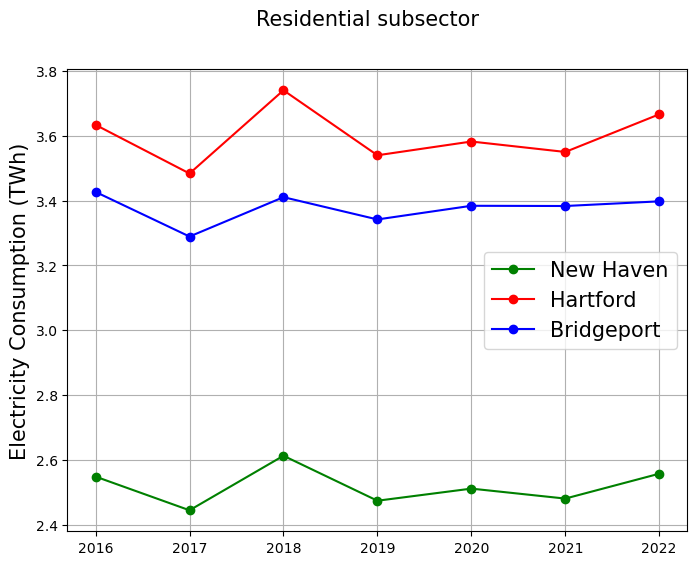

In [129]:
fig = plt.figure(figsize=(8,6))
fig.suptitle('Residential subsector',fontsize=15)
actual, = plt.plot(electr_residential.index, electr_residential ['New Haven-Milford (NHM)']/1000000000, 'go-', label='New Haven')
actual, = plt.plot(electr_residential.index, electr_residential ['Hartford-East Hartford-Middletown (HEM)']/1000000000, 'ro-', label='Hartford')
actual, = plt.plot(electr_residential.index, electr_residential ['Bridgeport-Stamford-Norwalk (BSN)']/1000000000, 'bo-', label='Bridgeport')
#plt.xlabel('Year',fontsize=18)
plt.ylabel('Electricity Consumption (TWh)',fontsize=15)
#plt.xticks(np.arange(min(electr_residential.index), max(electr_residential.index)+1, 1)) 
plt.legend(fontsize=15)
plt.grid()
#plt.savefig('images/avetemp.png',bbox_inches='tight')
plt.savefig('../../../figures/residential-electricity-consumption-1960-2022.png', dpi=600, bbox_inches='tight')

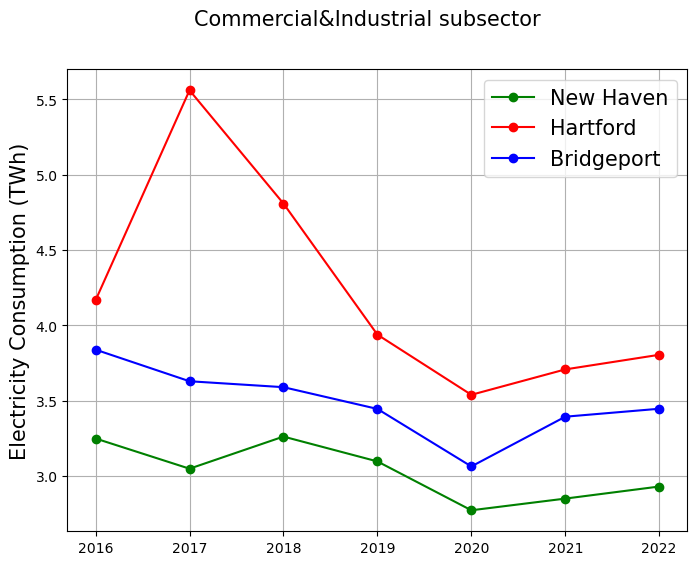

In [130]:
fig = plt.figure(figsize=(8,6))
fig.suptitle('Commercial&Industrial subsector',fontsize=15)
actual, = plt.plot(electr_commer_indust.index, electr_commer_indust['New Haven-Milford (NHM)']/1000000000, 'go-', label='New Haven')
actual, = plt.plot(electr_commer_indust.index, electr_commer_indust['Hartford-East Hartford-Middletown (HEM)']/1000000000, 'ro-', label='Hartford')
actual, = plt.plot(electr_commer_indust.index, electr_commer_indust['Bridgeport-Stamford-Norwalk (BSN)']/1000000000, 'bo-', label='Bridgeport')
#plt.xlabel('Year',fontsize=18)
plt.ylabel('Electricity Consumption (TWh)',fontsize=15)
#plt.xticks(np.arange(min(electr_residential.index), max(electr_residential.index)+1, 1)) 
plt.legend(fontsize=15)
#plt.savefig('images/avetemp.png',bbox_inches='tight')
plt.grid()
plt.savefig('../../../figures/commercial-industrial-electricity-consumption-1960-2022.png', dpi=600, bbox_inches='tight')

In [131]:
#split the test and trainig set
split_index = round(len(electr_residential)*0.8)
df_train = electr_residential.iloc[:split_index].copy()
df_test = electr_residential.iloc[split_index:].copy()

In [132]:
NHM_train = df_train['New Haven-Milford (NHM)']/1000000000
NHM_test = df_test['New Haven-Milford (NHM)']/1000000000
mod = AutoReg(NHM_train, lags=2, old_names=False)
res = mod.fit()
print(res.summary())

                               AutoReg Model Results                               
Dep. Variable:     New Haven-Milford (NHM)   No. Observations:                    6
Model:                          AutoReg(2)   Log Likelihood                   7.628
Method:                    Conditional MLE   S.D. of innovations              0.036
Date:                     Tue, 20 Feb 2024   AIC                             -7.256
Time:                             11:00:58   BIC                             -9.711
Sample:                                  2   HQIC                           -12.643
                                         6                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          5.0962      2.116      2.408      0.016       0.949       9.244
New Haven-Milford (NHM).L1    -0.8192      

C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


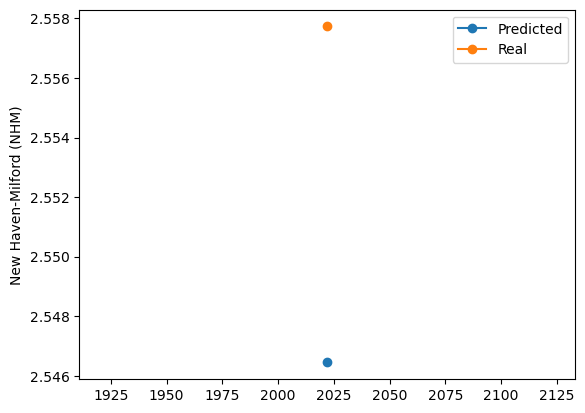

In [133]:
#making predictions on test set and compare
pred=res.predict(start=len(NHM_train),end=len(electr_residential)-1,dynamic=False)

# Define a new index
new_index = [2022]

# Convert Series to DataFrame with the first column as the index
predf = pd.DataFrame(list(pred.items()), columns=['Year', 'New Haven-Milford (NHM)'])
predf['Year']=new_index
#predf['Year'] = pd.to_datetime(predf['Year'], format='%Y')  # Convert the 'Year' column to datetime

# Set the 'Year' column as the index
predf.set_index('Year', inplace=True)

# Plot DataFrame 1
plt.plot(predf.index, predf['New Haven-Milford (NHM)'], label='Predicted', marker='o')

# Plot DataFrame 2
plt.plot(NHM_test.index, NHM_test, label='Real', marker='o')

# Customize the plot
#plt.xlabel('Year')
plt.ylabel('New Haven-Milford (NHM)')
#plt.title('Comparison of GHG Emissions between DataFrames')
plt.legend()

# Show the plot
plt.show()

<span style="font-family: verdana; color: green; font-size: 20px;font-weight: bold;">ARIMAX Model</span>

In [149]:
#sarima model 
#find a function to search order 
# Fit the model
mod = sm.tsa.arima.ARIMA(NHM_train, order=(2,0,0))#exog = array of publishsed VMT. inside of the function.
#what are existing forecasting, few slides 
res = mod.fit()
print(res.summary())

                                  SARIMAX Results                                  
Dep. Variable:     New Haven-Milford (NHM)   No. Observations:                    6
Model:                      ARIMA(2, 0, 0)   Log Likelihood                  11.058
Date:                     Tue, 20 Feb 2024   AIC                            -14.117
Time:                             11:02:24   BIC                            -14.950
Sample:                                  0   HQIC                           -17.451
                                       - 6                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5131      0.011    233.610      0.000       2.492       2.534
ar.L1         -0.8338      0.528     -1.580      0.114      -1.868       0.200
ar.L2       

C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [150]:
# Forecast on training data
train_forecast = res.get_prediction(start=0, end=len(NHM_train)-1)
train_forecast_mean = train_forecast.predicted_mean
train_forecast_mean_re = train_forecast_mean
train_conf_int = train_forecast.conf_int()

new_index = [2022]

# Forecast on test data
test_forecast = res.get_prediction(start=len(NHM_train), end=len(NHM_train)+len(NHM_test)-1)
test_forecast_mean = test_forecast.predicted_mean
test_conf_int = test_forecast.conf_int()
test_conf_int.index = new_index


# Convert Series to DataFrame with the first column as the index
test_forecast_df = pd.DataFrame(list(test_forecast_mean.items()), columns=['Year', 'New Haven-Milford (NHM)'])
test_forecast_df['Year'] = new_index

# Set the 'Year' column as the index
test_forecast_df.set_index('Year', inplace=True)

train_forecast_mean_re = train_forecast_mean

C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [151]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Extract the actual values for the test set
actual_values = NHM_test
# Extract the predicted values from the test forecast
predicted_values = test_forecast_df['New Haven-Milford (NHM)']

# Calculate MAE
mae = mean_absolute_error(actual_values, predicted_values)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))

# Calculate MAPE
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

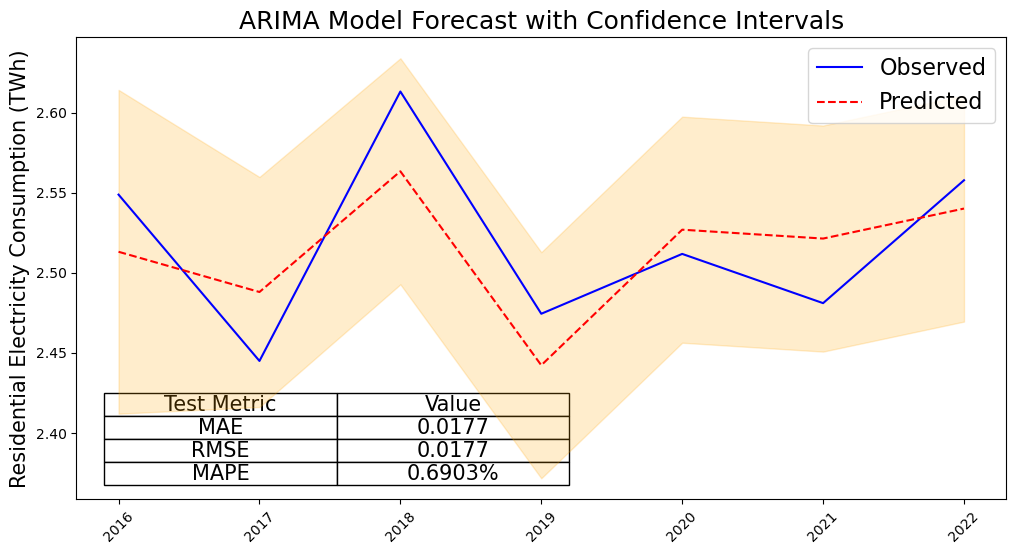

In [152]:
import matplotlib.pyplot as plt
import numpy as np


# Plotting the results with confidence bands
plt.figure(figsize=(12, 6))

#combine the test and train data together
concatenated_observed = pd.concat([NHM_train,NHM_test])

#combine the predicted test and train data together
concatenated_predicted = pd.concat([train_forecast_mean_re, test_forecast_df['New Haven-Milford (NHM)']])

#combine the confidence interval of train and test data
concatenated_interval = pd.concat([train_conf_int, test_conf_int])


#plot the observed value
plt.plot(concatenated_observed.index, concatenated_observed, label='Observed', color='blue')


#plot the predicted value
plt.plot(concatenated_predicted.index, concatenated_predicted, label='Predicted', color='red', linestyle='--')


# Plot confidence bands for training data
plt.fill_between(concatenated_interval.index, concatenated_interval.iloc[:, 0], concatenated_interval.iloc[:, 1], color='orange', alpha=0.2)

#combine the index
combined_index = np.concatenate([NHM_train.index, test_forecast_df.index])

plt.title('ARIMA Model Forecast with Confidence Intervals', fontsize=18)
# Adjust x-axis ticks and labels
plt.xticks(combined_index, rotation=45)

#plt.xlabel('Time', fontsize=16)
plt.ylabel('Residential Electricity Consumption (TWh)', fontsize=15)
plt.legend(fontsize=16)

# Set x-axis and y-axis tick labels with fontsize
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

#create a table to show the MAE and RMSE

# Create a table inside the plot
table_data = [['Test Metric', 'Value'], 
              ['MAE', f'{mae:.4f}'], 
              ['RMSE', f'{rmse:.4f}'], 
              ['MAPE', f'{mape:.4f}%']]
table = plt.table(cellText=table_data, loc='lower left', cellLoc='center', bbox=[0.03, 0.03, 0.5, 0.2], colWidths=[0.2, 0.2, 0.8, 0.8])

# Set font size for the table
table.auto_set_font_size(False)
table.set_fontsize(15)  # Adjust the font size as needed

plt.savefig('../../../figures/arimax-residential-electricity-NewHaven.png', dpi=600, bbox_inches='tight')

<span style="font-family: verdana; color: green; font-size: 20px;font-weight: bold;">ARIMAX model with exogenous variable</span>

In [153]:
exog_train = df_train['New Haven Population'].astype(float) 
exog_test = df_test['New Haven Population'].astype(float) 
# Combine the exogenous variables

# Fit the model
mod = sm.tsa.arima.ARIMA(NHM_train, order=(2,0,0), exog=exog_train)#exog = array of publishsed VMT. inside of the function.
#what are existing forecasting, few slides 
res = mod.fit()
print(res.summary())

                                  SARIMAX Results                                  
Dep. Variable:     New Haven-Milford (NHM)   No. Observations:                    6
Model:                      ARIMA(2, 0, 0)   Log Likelihood                  11.198
Date:                     Tue, 20 Feb 2024   AIC                            -12.396
Time:                             11:02:35   BIC                            -13.437
Sample:                                  0   HQIC                           -16.564
                                       - 6                                         
Covariance Type:                       opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    4.0937      0.007    609.029      0.000       4.081       4.107
New Haven Population -2.681e-06   1.37e-08   -196.218      0.

C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [154]:
# Forecast on training data
train_forecast = res.get_prediction(start=0, end=len(NHM_train)-1, exog=exog_train)
train_forecast_mean = train_forecast.predicted_mean
train_forecast_mean_re = train_forecast_mean
train_conf_int = train_forecast.conf_int()

new_index = [2022]


In [155]:
# Forecast on test data
test_forecast = res.get_prediction(start=len(NHM_train), end=len(NHM_train)+len(NHM_test)-1, exog=exog_test)
test_forecast_mean = test_forecast.predicted_mean
test_conf_int = test_forecast.conf_int()
test_conf_int.index = new_index


# Convert Series to DataFrame with the first column as the index
test_forecast_df = pd.DataFrame(list(test_forecast_mean.items()), columns=['Year', 'New Haven GHG Emissions'])
test_forecast_df['Year'] = new_index

# Set the 'Year' column as the index
test_forecast_df.set_index('Year', inplace=True)

train_forecast_mean_re = train_forecast_mean

C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [156]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Extract the actual values for the test set
actual_values = NHM_test
# Extract the predicted values from the test forecast
predicted_values = test_forecast_df['New Haven GHG Emissions']

# Calculate MAE
mae = mean_absolute_error(actual_values, predicted_values)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))

# Calculate MAPE
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

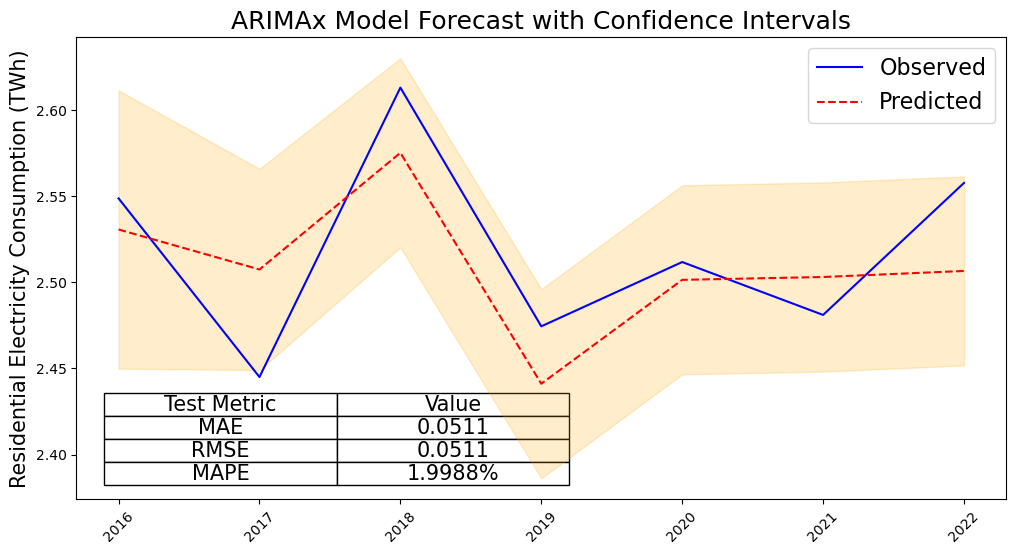

In [159]:
# Plotting the results with confidence bands
plt.figure(figsize=(12, 6))

#combine the test and train data together
concatenated_observed = pd.concat([NHM_train,NHM_test])

#combine the predicted test and train data together
concatenated_predicted = pd.concat([train_forecast_mean_re, test_forecast_df['New Haven GHG Emissions']])

#combine the confidence interval of train and test data
concatenated_interval = pd.concat([train_conf_int, test_conf_int])


#plot the observed value
plt.plot(concatenated_observed.index, concatenated_observed, label='Observed', color='blue')


#plot the predicted value
plt.plot(concatenated_predicted.index, concatenated_predicted, label='Predicted', color='red', linestyle='--')



# Plot confidence bands for training data
plt.fill_between(concatenated_interval.index, concatenated_interval.iloc[:, 0], concatenated_interval.iloc[:, 1], color='orange', alpha=0.2)

#combine the index
combined_index = np.concatenate([NHM_train.index, test_forecast_df.index])

plt.title('ARIMAx Model Forecast with Confidence Intervals', fontsize=18)
# Adjust x-axis ticks and labels
plt.xticks(combined_index, rotation=45)

#plt.xlabel('Time', fontsize=16)
plt.ylabel('Residential Electricity Consumption (TWh)', fontsize=15)
plt.legend(fontsize=16)

# Set x-axis and y-axis tick labels with fontsize
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)


#create a table to show the MAE and RMSE

# Create a table inside the plot
table_data = [['Test Metric', 'Value'], 
              ['MAE', f'{mae:.4f}'], 
              ['RMSE', f'{rmse:.4f}'], 
              ['MAPE', f'{mape:.4f}%']]
table = plt.table(cellText=table_data, loc='lower left', cellLoc='center', bbox=[0.03, 0.03, 0.5, 0.2], colWidths=[0.2, 0.2, 0.8, 0.8])

# Set font size for the table
table.auto_set_font_size(False)
table.set_fontsize(15)  # Adjust the font size as needed


plt.savefig('../../../figures/arimax-population-residential-electricity-NewHaven.png', dpi=600, bbox_inches='tight')

In [109]:
# commercial-industrial emissions
#split the test and trainig set
split_index = round(len(electr_commer_indust)*0.8)
df_train = electr_commer_indust.iloc[:split_index].copy()
df_test = electr_commer_indust.iloc[split_index:].copy()
NHM_train = df_train['GHG Emissions_NHM (MMTCO2e)']
NHM_test = df_test['GHG Emissions_NHM (MMTCO2e)']

mod = sm.tsa.arima.ARIMA(NHM_train, order=(3,0,2))#exog = array of publishsed VMT. inside of the function.
#what are existing forecasting, few slides 
res = mod.fit()
print(res.summary())

                                    SARIMAX Results                                    
Dep. Variable:     GHG Emissions_NHM (MMTCO2e)   No. Observations:                    6
Model:                          ARIMA(3, 0, 2)   Log Likelihood                  10.911
Date:                         Sun, 18 Feb 2024   AIC                             -7.821
Time:                                 18:09:39   BIC                             -9.279
Sample:                                      0   HQIC                           -13.656
                                           - 6                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7547      0.044     17.074      0.000       0.668       0.841
ar.L1          0.3165      5.961      0.053      0.958     

C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\peiya

In [110]:
electr_commer_indust

,GHG Emissions_NHM (MMTCO2e),GHG Emissions_HEM (MMTCO2e),GHG Emissions_BSN (MMTCO2e),New Haven Population
Unnamed: 0,,,,
2016,0.801325,1.027822,0.946878,583000
2017,0.751876,1.371800,0.895129,587000
2018,0.804491,1.186267,0.885426,590000
2019,0.763801,0.971495,0.849796,591000
2020,0.683755,0.872928,0.755577,593000
2021,0.702893,0.914548,0.837060,595000
2022,0.722667,0.938482,0.850076,597000


In [111]:
# Forecast on training data
train_forecast = res.get_prediction(start=0, end=len(NHM_train)-1)
train_forecast_mean = train_forecast.predicted_mean
train_forecast_mean_re = train_forecast_mean
train_conf_int = train_forecast.conf_int()

new_index = [2022]

# Forecast on test data
test_forecast = res.get_prediction(start=len(NHM_train), end=len(NHM_train)+len(NHM_test)-1)
test_forecast_mean = test_forecast.predicted_mean
test_conf_int = test_forecast.conf_int()
test_conf_int.index = new_index


# Convert Series to DataFrame with the first column as the index
test_forecast_df = pd.DataFrame(list(test_forecast_mean.items()), columns=['Year', 'New Haven GHG Emissions'])
test_forecast_df['Year'] = new_index

# Set the 'Year' column as the index
test_forecast_df.set_index('Year', inplace=True)

train_forecast_mean_re = train_forecast_mean

C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [112]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Extract the actual values for the test set
actual_values = NHM_test
# Extract the predicted values from the test forecast
predicted_values = test_forecast_df['New Haven GHG Emissions']

# Calculate MAE
mae = mean_absolute_error(actual_values, predicted_values)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))

# Calculate MAPE
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

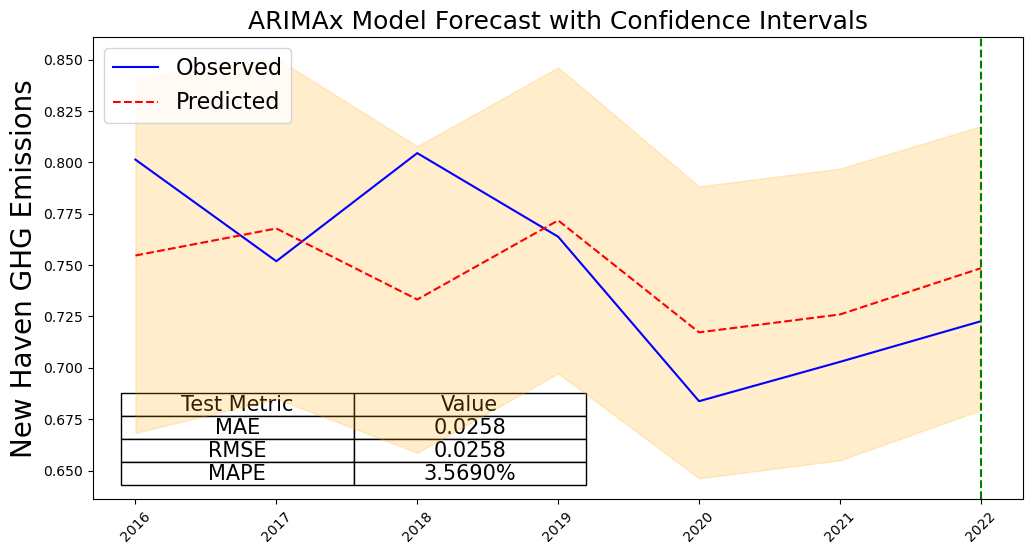

In [113]:
import matplotlib.pyplot as plt
import numpy as np


# Plotting the results with confidence bands
plt.figure(figsize=(12, 6))

#combine the test and train data together
concatenated_observed = pd.concat([NHM_train,NHM_test])

#combine the predicted test and train data together
concatenated_predicted = pd.concat([train_forecast_mean_re, test_forecast_df['New Haven GHG Emissions']])

#combine the confidence interval of train and test data
concatenated_interval = pd.concat([train_conf_int, test_conf_int])


#plot the observed value
plt.plot(concatenated_observed.index, concatenated_observed, label='Observed', color='blue')


#plot the predicted value
plt.plot(concatenated_predicted.index, concatenated_predicted, label='Predicted', color='red', linestyle='--')


# Plot confidence bands for training data
plt.fill_between(concatenated_interval.index, concatenated_interval.iloc[:, 0], concatenated_interval.iloc[:, 1], color='orange', alpha=0.2)

#combine the index
combined_index = np.concatenate([NHM_train.index, test_forecast_df.index])

plt.title('ARIMAx Model Forecast with Confidence Intervals', fontsize=18)
# Adjust x-axis ticks and labels
plt.xticks(combined_index, rotation=45)

#plt.xlabel('Time', fontsize=16)
plt.ylabel('New Haven GHG Emissions', fontsize=20)
plt.legend(fontsize=16)

# Set x-axis and y-axis tick labels with fontsize
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

#create a table to show the MAE and RMSE

# Create a table inside the plot
table_data = [['Test Metric', 'Value'], 
              ['MAE', f'{mae:.4f}'], 
              ['RMSE', f'{rmse:.4f}'], 
              ['MAPE', f'{mape:.4f}%']]
table = plt.table(cellText=table_data, loc='lower left', cellLoc='center', bbox=[0.03, 0.03, 0.5, 0.2], colWidths=[0.2, 0.2, 0.8, 0.8])

# Set font size for the table
table.auto_set_font_size(False)
table.set_fontsize(15)  # Adjust the font size as needed


# Add a vertical line at the x-axis for the year 2016
plt.axvline(x=2022, color='green', linestyle='--', label='Year 2015 (X-axis)')